# Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
import time
from scipy.interpolate import PchipInterpolator
import scipy
from tqdm import tqdm

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from itertools import chain

# Data Processing

In [19]:
df_train = pd.read_csv("../files/data/Surface_Crack/RN_isolated_TEST.csv", index_col=0)
df_train = df_train.drop(columns=['mgfw', 'mg', 'E', 'sigma', 'a'])
df_train = df_train.reindex(['a/c', 'a/t', 'c/b', 'phi', "KI"], axis=1)
d_train = df_train.to_numpy()
df_train, d_train.shape

(          a/c    a/t     c/b       phi         KI
 152098  1.425  0.225  0.0125  0.007405  19.194895
 152099  1.225  0.225  0.0125  0.007405  19.747866
 152100  0.625  0.225  0.0125  0.007405  20.432790
 152101  1.025  0.225  0.0125  0.007405  20.196854
 152102  0.825  0.225  0.0125  0.007405  20.502258
 ...       ...    ...     ...       ...        ...
 303607  1.025  0.825  0.4500  3.134188  54.981590
 303608  1.225  0.825  0.4500  3.134188  51.662312
 303609  0.825  0.825  0.4500  3.134188  58.938067
 303610  1.425  0.825  0.4500  3.134188  48.885738
 303611  1.625  0.825  0.4500  3.134190  46.518043
 
 [151514 rows x 5 columns],
 (151514, 5))

In [20]:
# Get unique combinations of the first four columns
SC_train_combinations = df_train.iloc[:, :3].drop_duplicates().to_numpy()

print(len(SC_train_combinations))

438


In [21]:
print("Different a/c values: ", np.unique(SC_train_combinations[:,0], axis=0))
print("Different a/t values: ", np.unique(SC_train_combinations[:,1], axis=0))
print("Different c/b values: ", np.unique(SC_train_combinations[:,2], axis=0))

Different a/c values:  [0.225 0.425 0.625 0.825 1.    1.025 1.225 1.425 1.625 1.815 2.025]
Different a/t values:  [0.225 0.325 0.425 0.525 0.625 0.725 0.825]
Different c/b values:  [0.0125 0.015  0.15   0.175  0.25   0.275  0.35   0.375  0.45  ]


In [22]:
min_phi = 6 * np.pi/180
max_phi = 174 * np.pi/180

min_phi, max_phi

(0.10471975511965977, 3.036872898470133)

In [23]:
SC_train_phi_regular_128 = np.linspace(min_phi, max_phi, 128)
d_final = np.zeros((len(SC_train_combinations)*128, 6))
for (i,combination) in enumerate(SC_train_combinations):
    data = np.zeros((128, 6))
    data[:,0] = i
    data[:,1] = combination[0]
    data[:,2] = combination[1]
    data[:,3] = combination[2]
    data[:,4] = SC_train_phi_regular_128
    indices = np.where((d_train[:, 0] == combination[0]) & 
                    (d_train[:, 1] == combination[1]) &
                    (d_train[:, 2] == combination[2])) 
    indices = indices[0]

    phi_vals = d_train[indices][:,-2]
    K_vals = d_train[indices][:,-1]
    phi_idxes = np.argsort(phi_vals)
    
    monotonic_phi_idxes = [phi_idxes[0]]
    prev_phi = phi_vals[phi_idxes[0]]
    for index in phi_idxes[1:]:
        now_phi = phi_vals[index]
        if now_phi > prev_phi:
            monotonic_phi_idxes.append(index)
            prev_phi = phi_vals[index]
    
    interp_func = PchipInterpolator(phi_vals[monotonic_phi_idxes], K_vals[monotonic_phi_idxes], extrapolate=False)

    data[:,5] = interp_func(SC_train_phi_regular_128)

    if np.isnan(data).any():
        print("WARNING: NaN at crack: ", i)

    else:
        d_final[i*128:i*128+128] = data

output_df = pd.DataFrame(d_final, columns=["c_index", "a/c", "a/t", "c/b", "phi", "K-T"])

# Save the cleaned and processed DataFrame to a new CSV file
output_df.to_csv("../files/data/FINAL_CSV/SURFACE_CRACK_TEST.csv", index=False)

# Data Viz

In [12]:
df = pd.read_csv("../files/data/FINAL_CSV/SURFACE_CRACK_TEST.csv")
df

,c_index,a/c,a/t,c/b,phi,K-T
0,0.0,1.425,0.225,0.0125,0.104720,19.597453
1,0.0,1.425,0.225,0.0125,0.127808,19.453829
2,0.0,1.425,0.225,0.0125,0.150895,19.312760
3,0.0,1.425,0.225,0.0125,0.173983,19.176130
4,0.0,1.425,0.225,0.0125,0.197071,19.044489
...,...,...,...,...,...,...
56059,437.0,0.425,0.825,0.4500,2.944522,63.939989
56060,437.0,0.425,0.825,0.4500,2.967609,64.259458
56061,437.0,0.425,0.825,0.4500,2.990697,64.674951
56062,437.0,0.425,0.825,0.4500,3.013785,65.205603


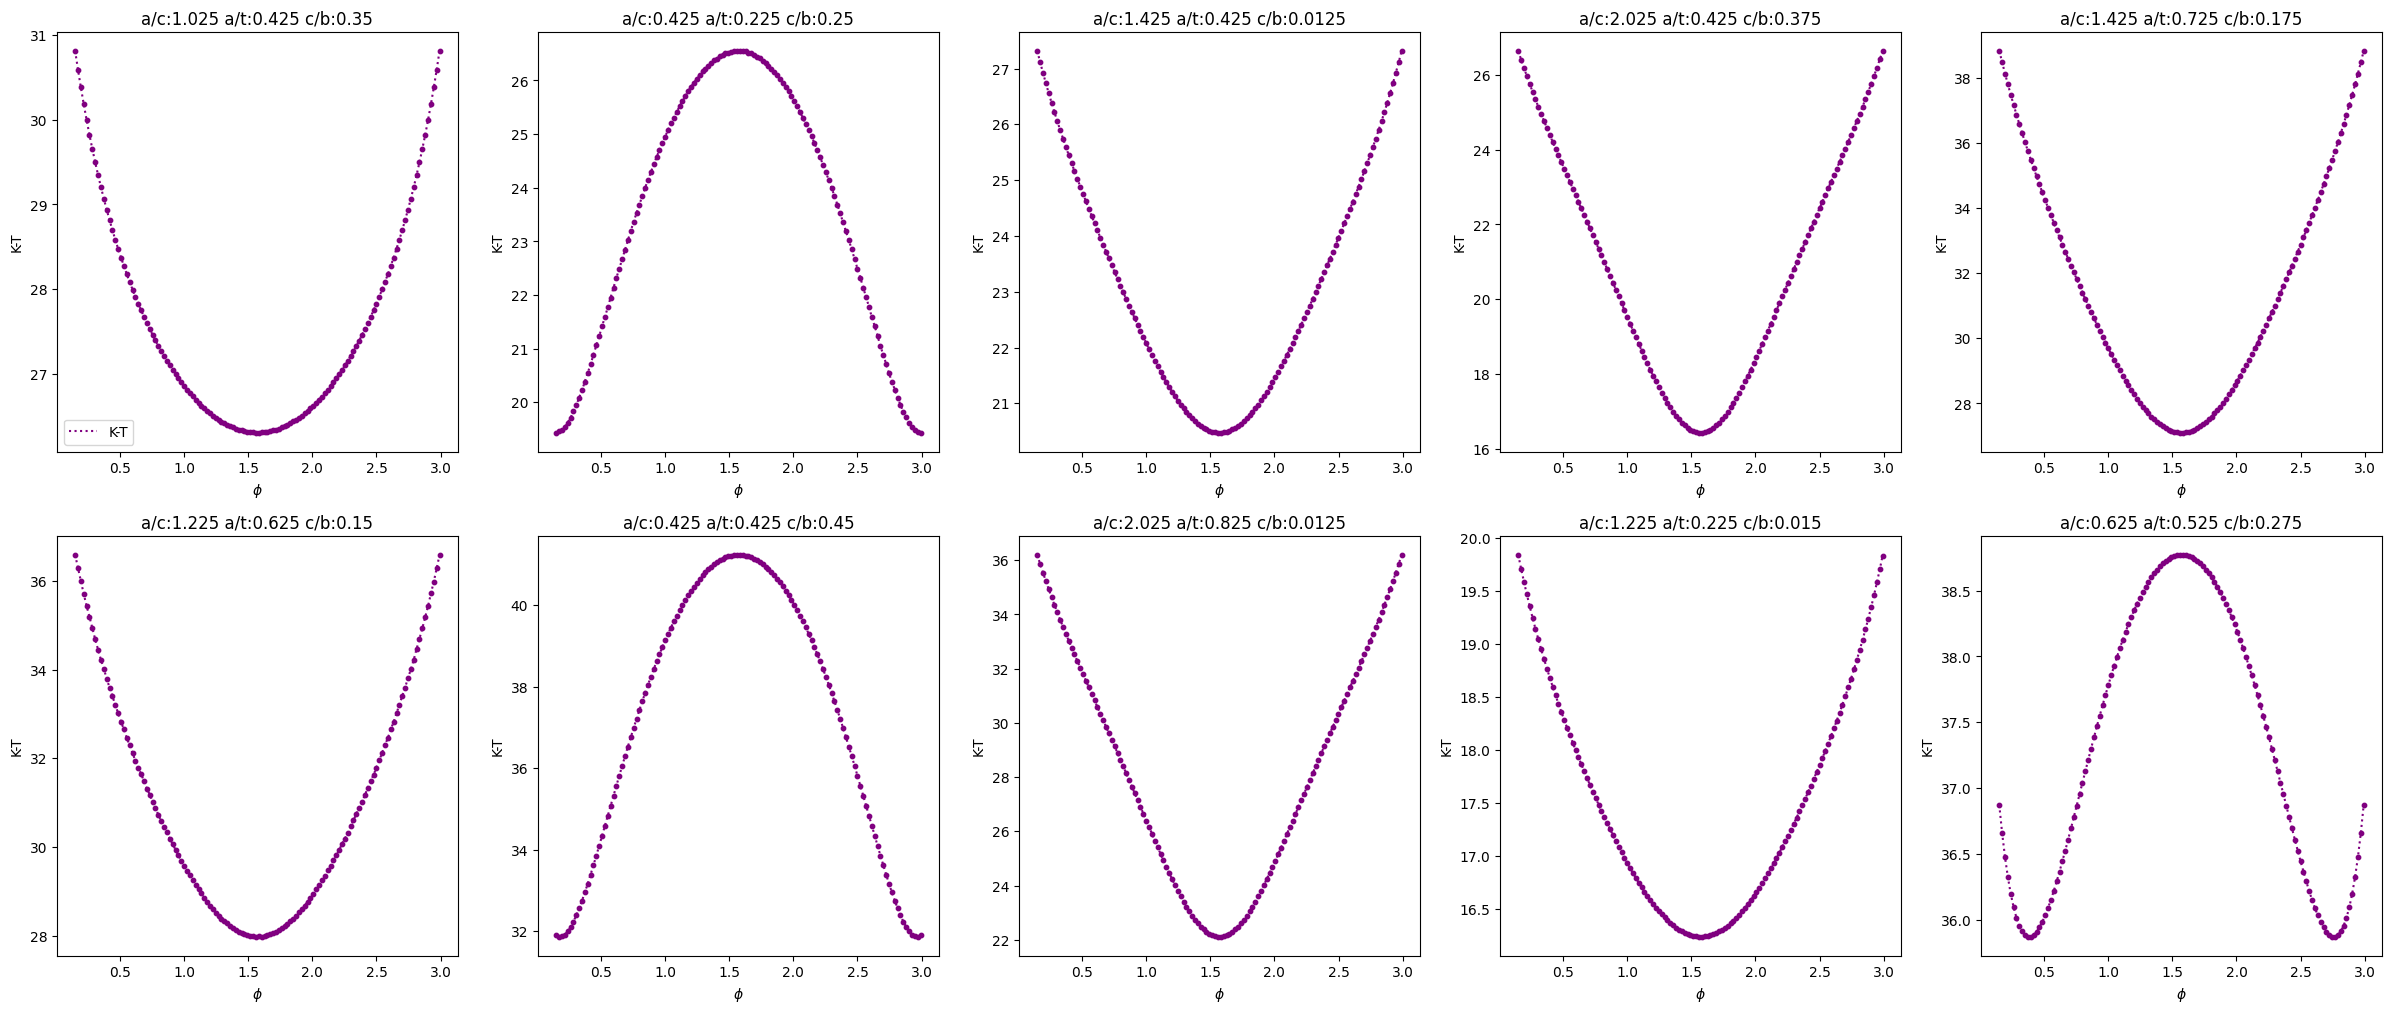

In [16]:
d = df.to_numpy()

num_crack = np.unique(d[:,0])

np.random.seed(0)
fig, axs = plt.subplots(2, 5, figsize=(30,12))
for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(num_crack))
        data = d[idx*128:idx*128+128]
        a_c = np.unique(data[:,1])
        a_t = np.unique(data[:,2])
        c_b = np.unique(data[:,3])

        assert len(a_c) == 1
        assert len(a_t) == 1
        assert len(c_b) == 1

        axs[i,j].scatter(data[:,-2], data[:,-1], color='purple', s=10)
        axs[i,j].plot(data[:,-2], data[:,-1], label="K-T", color='purple', linestyle=":")

        axs[i,j].set_title("a/c:{} a/t:{} c/b:{}".format(a_c[0], a_t[0], c_b[0]))
        axs[i,j].set_ylabel("K-T")
        axs[i,j].set_xlabel(r"$\phi$")
        
        if i == 0 and j == 0:
            axs[i,j].legend()

plt.show()